In [6]:
import torchvision
from torch.utils.data import DataLoader

normalization = torchvision.transforms.Normalize([0.485],[0.229])
transfrom = torchvision.transforms.Compose([
    # torchvision.transforms.Resize((64,64)),
    torchvision.transforms.ToTensor(),
    normalization])

train_ds = torchvision.datasets.FashionMNIST(root="../data", 
                                            train= True, 
                                            download=True,
                                            transform = transfrom)
test_ds = torchvision.datasets.FashionMNIST(root="../data", 
                                            train= True, 
                                            download=True,
                                            transform= transfrom)

# DataLoader(train_ds, batch_size, True)
img, label = train_ds[0]
img.shape, label

(torch.Size([1, 28, 28]), 9)

In [7]:
img

tensor([[[-2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179,
          -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179,
          -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179,
          -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179,
          -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179,
          -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179,
          -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179,
          -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179,
          -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179,
          -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179,
          -2.1179, -2.1179, -2.1179, -2.1179, -2

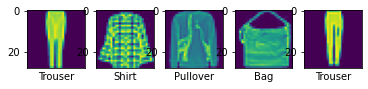

In [8]:
import matplotlib.pyplot as plt
import math

batch_size = 128
train_loader, test_loader = [DataLoader(ds, batch_size, True, num_workers= 4) 
                                for ds in (train_ds, test_ds)]

classes = torchvision.datasets.FashionMNIST.classes

def get_classnames(indices):
    return [classes[idx] for idx in indices]
    
def draw_imgs(imgs, labels, rows=1):
    cols = math.ceil(len(imgs)/rows)
    
    for i, img in enumerate(imgs):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img)
        ax.set_xlabel(labels[i])
        ax.set_xticks([])

for X, Y in train_loader:
    samples = X[:5]
    labels = Y[:5]
    
    draw_imgs(samples.permute(0,2,3,1), get_classnames(labels), 1)
    break

In [9]:
print("total batches", len(train_loader), len(test_loader))

total batches 469 469


In [10]:
from torch import nn
import torch
from tqdm import tqdm

class Classifier(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        # resnet = torchvision.models.resnet18(True)
        # resnet.requires_grad_(False)
        # resnet.fc = nn.Linear(resnet.fc.in_features, num_class)

        # self.expand = nn.Conv2d(1, 3, 1)
        # self.resnet = resnet

        self.fc = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, num_class))
    
    def forward(self, X):
        # X = self.expand(X)
        # return self.resnet(X)
        X = X.reshape(X.shape[0], -1)
        return self.fc(X)

model = Classifier(len(classes))
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs ,lr = 30,1e-3

optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()
model.to(device)
    
def evaluate(model, dataloader, device):
    training = model.training
    model.eval()
    corrects, total = 0, 0
    for X, Y in dataloader:
        with torch.no_grad():
            X, Y = X.to(device), Y.to(device)
            y_hat = model(X)
            y_hat = y_hat.argmax(dim = -1)
            corrects += (y_hat.reshape(-1) == Y).sum()
            total+= Y.numel()
    model.train(training)
    return corrects/total

def train(model, trainloader, testloader, epochs, optimizer, criterion, device):
    for epoch in range(epochs):
        losses, corrects, total,eval_acc = 0, 0, 0 ,0
        model.train()
        with tqdm(total = len(trainloader)) as p:
            for i,(X, Y) in enumerate(trainloader):
                X, Y = X.to(device), Y.to(device)
                optimizer.zero_grad()
                y_hat = model(X)
                loss = criterion(y_hat, Y)
                loss.backward()
                optimizer.step()

                losses += loss.item()
                corrects += (y_hat.argmax(-1) == Y).sum()
                total += Y.numel()
                p.update()
                if i == (len(trainloader)-1):
                    eval_acc = evaluate(model, testloader, device)
                    
                p.set_description(f"{epoch+1}/{epochs}, train(l ={losses * batch_size / total:.2f}, acc={100*corrects/total:.2f}%)"
                                    f",test(acc={100*eval_acc:.2f}%)")
        

train(model, train_loader, test_loader, epochs, optimizer, criterion, device)

1/30, train(l =0.55, acc=80.37%),test(acc=86.09%): 100%|██████████| 469/469 [00:11<00:00, 40.26it/s]
2/30, train(l =0.40, acc=85.75%),test(acc=86.22%): 100%|██████████| 469/469 [00:11<00:00, 41.22it/s]
3/30, train(l =0.36, acc=87.08%),test(acc=89.18%): 100%|██████████| 469/469 [00:11<00:00, 40.34it/s]
4/30, train(l =0.33, acc=88.16%),test(acc=88.55%): 100%|██████████| 469/469 [00:11<00:00, 40.56it/s]
5/30, train(l =0.31, acc=88.67%),test(acc=89.30%): 100%|██████████| 469/469 [00:11<00:00, 40.63it/s]
6/30, train(l =0.29, acc=89.47%),test(acc=90.37%): 100%|██████████| 469/469 [00:11<00:00, 39.78it/s]
7/30, train(l =0.28, acc=89.75%),test(acc=91.03%): 100%|██████████| 469/469 [00:11<00:00, 40.74it/s]
8/30, train(l =0.26, acc=90.50%),test(acc=91.66%): 100%|██████████| 469/469 [00:11<00:00, 40.26it/s]
9/30, train(l =0.25, acc=90.90%),test(acc=92.05%): 100%|██████████| 469/469 [00:11<00:00, 40.24it/s]
10/30, train(l =0.24, acc=91.31%),test(acc=92.24%): 100%|██████████| 469/469 [00:11<00:00, 

In [17]:
train(model, train_loader, test_loader, 10, optimizer, criterion, device)

1/10, train(l =0.08, acc=97.42%),test(acc=97.75%): 100%|██████████| 469/469 [00:11<00:00, 40.02it/s]
2/10, train(l =0.08, acc=97.17%),test(acc=97.81%): 100%|██████████| 469/469 [00:11<00:00, 40.19it/s]
3/10, train(l =0.07, acc=97.54%),test(acc=98.03%): 100%|██████████| 469/469 [00:11<00:00, 41.27it/s]
4/10, train(l =0.06, acc=97.72%),test(acc=98.15%): 100%|██████████| 469/469 [00:11<00:00, 40.86it/s]
5/10, train(l =0.07, acc=97.42%),test(acc=98.25%): 100%|██████████| 469/469 [00:11<00:00, 41.01it/s]
6/10, train(l =0.05, acc=98.18%),test(acc=98.53%): 100%|██████████| 469/469 [00:11<00:00, 40.39it/s]
7/10, train(l =0.07, acc=97.78%),test(acc=98.42%): 100%|██████████| 469/469 [00:11<00:00, 40.25it/s]
8/10, train(l =0.06, acc=97.86%),test(acc=98.48%): 100%|██████████| 469/469 [00:11<00:00, 40.96it/s]
9/10, train(l =0.07, acc=97.72%),test(acc=96.94%): 100%|██████████| 469/469 [00:11<00:00, 40.72it/s]
10/10, train(l =0.06, acc=97.92%),test(acc=98.72%): 100%|██████████| 469/469 [00:11<00:00, 

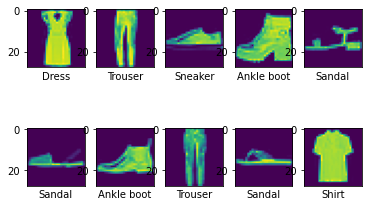

In [16]:
for X,Y in test_loader:
    examples = X[:10].to(device)
    y_hat = model(examples)
    y_hat = y_hat.argmax(-1).cpu()
    labels = get_classnames(y_hat)
    draw_imgs(examples.cpu().permute(0,2,3,1), labels, 2)
    break